<style>
    .title_container {
        margin: auto;
        background: rgb(81,92,103);
        background: linear-gradient(90deg, rgba(81,92,103,1) 36%, rgba(12,35,66,1) 62%);
        border-radius: 7px;
        color: white;
        text-align:center;
        width:75%;
        padding-top:2%;
        padding-bottom:2%;
    }
    
    .question_container {
        margin: auto;
        background: rgb(84,138,142);
        background: linear-gradient(90deg, rgba(84,138,142,1) 41%, rgba(145,201,73,1) 81%);
        border-radius: 7px;
        color: white;
        text-align:left;
        width:75%;
        padding-top:1%;
        padding-bottom:1%;
        padding-left: 2%;
        margin-top:2%;
    }
    
    .question_container p {
        font-size: 16px;
    }
    
    .code_span {
        background-color: #E2E7EC;
        padding:2px;
        border-radius:1px;
        font-family: Consolas,monaco,monospace;
        color:black;
    }
</style>

<div class ='title_container'>
    <h1> Análisis de Datos II </h1>
    <h2> Profesor: Oldemar Rodríguez </h2>
    <h3> Estudiante: Jimmy Calvo Monge </h3>
    <h3> Carné: B31281 </h3>
    <hr style='color:white; width:80%;'>
    <h4> TAREA 7 </h4>
    <h4> Fecha de entrega: 9 de Octubre de 2022 </h4>
</div>

Importamos los módulos necesarios para resolver esta tarea.

In [2]:
### Basicos
import numpy as np
import pandas as pd
from pandas import DataFrame

### Utilidades/Varios
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.tree import export_graphviz
from sklearn import tree
import seaborn as sns
import time
import graphviz
import os

### Training/Testing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### predictPy
from predictPy import Analisis_Predictivo

### Modelos:
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

In [3]:
def indices_general(MC, nombres = None):
    precision_global = np.sum(MC.diagonal()) / np.sum(MC)
    error_global     = 1 - precision_global
    precision_categoria  = pd.DataFrame(MC.diagonal()/np.sum(MC,axis = 1)).T
    if nombres!=None:
        precision_categoria.columns = nombres
    return {"Matriz de Confusión":MC, 
            "Precisión Global":   precision_global, 
            "Error Global":       error_global, 
            "Precisión por categoría":precision_categoria}

### Clase MatConf de la Tarea 2

class MatConf:
    
    def __init__(self,matriz):
        
        self.mat_conf = matriz
        
        VN = self.mat_conf[0,0]
        VP = self.mat_conf[1,1]
        FP = self.mat_conf[0,1]
        FN = self.mat_conf[1,0]
        
        dict_medidas = {
            'Precisión Global' : (VN+VP)/(VN+FP+FN+VP),
            'Error Global' : (FN+FP)/(VN+FP+FN+VP),
            'Precisión Positiva (PP)' : VP/(FN+VP),
            'Precisión Negativa (PN)' : VN/(VN+FP),
            'Proporción de Falsos Positivos (PFP)' : FP/(VN+FP),
            'Proporción de Falsos Negativos (PFN)' : FN/(FN+VP),
            'Asertividad Positiva (AP)' : VP/(FP+VP),
            'Asertividad Negativa (AN)' : VN/(VN+FN)
        }
        self.dict_medidas = dict_medidas
        
    def __str__(self):
        mensaje="Estos son los resultados para esta matriz de confusion:"
        for key in list(self.dict_medidas.keys()):
            mensaje = mensaje + f"\n - {key}: {self.dict_medidas[key]}"
        return mensaje

<div class='question_container'>
    <h2> Pregunta 1 </h2>
    <p> La tabla de datos novatosNBA.csv contiene diferentes métricas de desempeño de novatos de la NBA en su primera temporada. Para esta tabla, las 21 primeras columnas corresponden a las variables predictoras y la variable Permanencia es la variable a predecir, la cual indica si el jugador permanece en la NBA luego de 5 años. La tabla contiene 1340 filas (individuos) y 21 columnas (variables), con la tabla realice lo siguiente:</p>
    <ul>
        <li> Use Bayes en Python para generar un modelo predictivo para la tabla novatosNBA.csv usando el 80% de los datos para la tabla aprendizaje y un 20% para la tabla testing. Obtenga los índices de precisión e interprete los resultados.</li>
        <li>Construya un DataFrame que compare el modelo generado en el ítem anterior contra los modelos vistos en las clases anteriores para la tabla novatosNBA.csv. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos?</li>
    </ul>
</div>

In [8]:
datos_novatos=pd.read_csv("novatosNBA.csv",sep=";")
datos_novatos

,PartidosJugados,MinutosJugados,PuntosPorJuego,PuntosCampoAnotados,PuntosCampoIntentados,PuntosCampoPorcentaje,Puntos3Anotados,Puntos3Intentados,Puntos3Porcentaje,TirosLibresRealizados,TirosLibresIntentados,TirosLibresPorcentaje,RebotesOfensivos,RebotesDefensivos,Rebotes,Asistencias,Robos,Bloqueos,PerdidaBalon,Permanencia
Nombre,,,,,,,,,,,,,,,,,,,,
Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chris Smith,80,15.8,4.3,1.6,3.6,43.3,0.0,0.2,14.3,1.2,1.5,79.2,0.4,0.8,1.2,2.5,0.6,0.2,0.8,0
Brent Price,68,12.6,3.9,1.5,4.1,35.8,0.1,0.7,16.7,0.8,1.0,79.4,0.4,1.1,1.5,2.3,0.8,0.0,1.3,1
Marlon Maxey,43,12.1,5.4,2.2,3.9,55.0,0.0,0.0,0.0,1.0,1.6,64.3,1.5,2.3,3.8,0.3,0.3,0.4,0.9,0


In [17]:
datos_novatos.dtypes

PartidosJugados            int64
MinutosJugados           float64
PuntosPorJuego           float64
PuntosCampoAnotados      float64
PuntosCampoIntentados    float64
PuntosCampoPorcentaje    float64
Puntos3Anotados          float64
Puntos3Intentados        float64
Puntos3Porcentaje        float64
TirosLibresRealizados    float64
TirosLibresIntentados    float64
TirosLibresPorcentaje    float64
RebotesOfensivos         float64
RebotesDefensivos        float64
Rebotes                  float64
Asistencias              float64
Robos                    float64
Bloqueos                 float64
PerdidaBalon             float64
Permanencia                int64
dtype: object

In [22]:
### Hay datos faltantes:
nas_dict={}
for col in datos_novatos.columns:
    nas_dict[col]=datos_novatos[col].isna().sum()
nas_dict

{'PartidosJugados': 0,
 'MinutosJugados': 0,
 'PuntosPorJuego': 0,
 'PuntosCampoAnotados': 0,
 'PuntosCampoIntentados': 0,
 'PuntosCampoPorcentaje': 0,
 'Puntos3Anotados': 0,
 'Puntos3Intentados': 0,
 'Puntos3Porcentaje': 11,
 'TirosLibresRealizados': 0,
 'TirosLibresIntentados': 0,
 'TirosLibresPorcentaje': 0,
 'RebotesOfensivos': 0,
 'RebotesDefensivos': 0,
 'Rebotes': 0,
 'Asistencias': 0,
 'Robos': 0,
 'Bloqueos': 0,
 'PerdidaBalon': 0,
 'Permanencia': 0}

El modelo de Naive Bayes dará error si hay datos faltantes. Son 11 observaciones que tienen datos faltantes en la columna `Puntos3Porcentaje`. Por el momento serán eliminadas.

In [23]:
datos_novatos=datos_novatos.dropna()

Creamos un objeto de la clase `Analisis_Predictivo` y vemos la distribución de la variable a predecir. Notamos que se trata de un problema ligeramente desbalanceado.

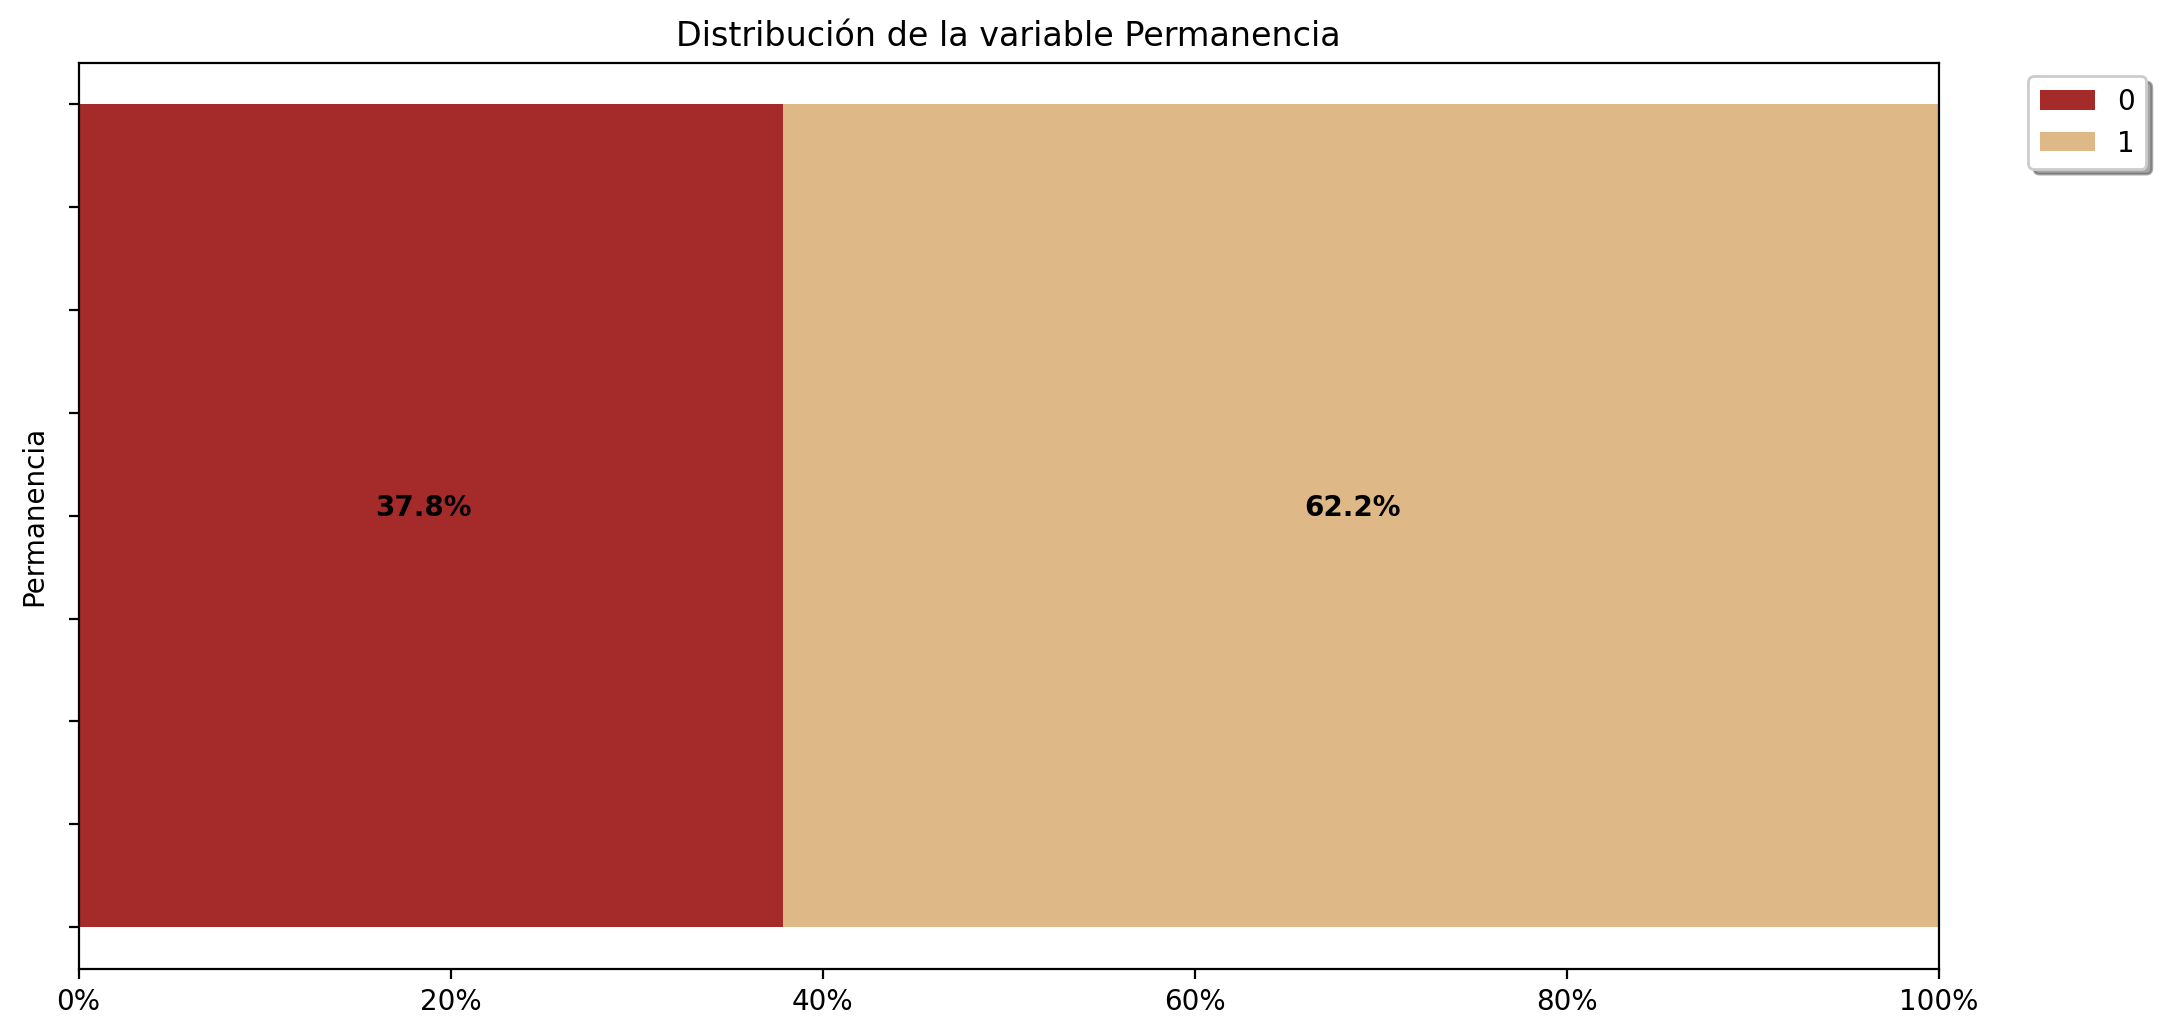

In [24]:
analisis_Novatos = Analisis_Predictivo(datos_novatos, predecir = "Permanencia")
analisis_Novatos.distribucion_variable_predecir()
plt.show()

Ahora ajustamos un modelo de Naive Bayes sobre estos datos usando las especificaciones del ejercicio.

In [25]:
# Usamos los parámetros por defecto
bayes = GaussianNB()

analisis_Novatos_pred = Analisis_Predictivo(
    datos_novatos,
    predecir = "Permanencia",
    modelo = bayes, 
    train_size = 0.8,
    random_state = 12
)

In [26]:
resultados = analisis_Novatos_pred.fit_predict_resultados(imprimir=False)

In [29]:
for indice in resultados:
    print(indice)
    print(resultados[indice])

Matriz de Confusión
[[80 23]
 [86 77]]
Precisión Global
0.5902255639097744
Error Global
0.40977443609022557
Precisión por categoría
          0         1
0  0.776699  0.472393


Hasta ahora no hemos usado esta tabla (novatosNBA.csv) con los modelos de las clases anteriores, o por lo menos no he podido encontrarla en el material, entonces voy a ajustar todos los modelos estudiados y haré la comparación final. Por simplicidad no haré la búsqueda de hiperparámetros para cada modelo, es decir efectuaré las comparaciones utilizando los parámetros por defecto.

Modelos a ajustar:

- KNN
- Árboles de Decisión
- Bosques Aleatorios
- AdaBoost
- XGBoost
- SVM's
- NaiveBayes

In [30]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Arboles de Decision
from sklearn.tree import DecisionTreeClassifier
# Bosques Aleatorios
from sklearn.ensemble import RandomForestClassifier
# Ada Boost
from sklearn.ensemble import AdaBoostClassifier
# XG Boost
from sklearn.ensemble import GradientBoostingClassifier
# SVM
from sklearn.svm import SVC

Para todos estos modelos vamos a crear los mismos datos train-test, los escalamos y mediremos las precisiones.

In [32]:
# Variables Predictoras
X = datos_novatos.drop(['Permanencia'],axis=1)
# Variable a predecir
y = datos_novatos['Permanencia'].ravel()

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#Estandarizamos los datos para aplicar SVM
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

for col in X_train.columns:
    sd_col=np.std(X_train[col])
    mean_col=np.mean(X_train[col])
    X_train_scaled[col]=[(obs-mean_col)/sd_col for obs in X_train[col]]
    X_test_scaled[col]=[(obs-mean_col)/sd_col for obs in X_test[col]]

In [39]:
modelos_ajustar=[]

instancia_knn = KNeighborsClassifier()
modelos_ajustar.append(instancia_knn)


instancia_arbol = DecisionTreeClassifier()
modelos_ajustar.append(instancia_arbol)


instancia_bosques = RandomForestClassifier()
modelos_ajustar.append(instancia_bosques)


instancia_tree = DecisionTreeClassifier(criterion="gini")
instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree)
modelos_ajustar.append(instancia_ada)

instancia_xgb = GradientBoostingClassifier()
modelos_ajustar.append(instancia_xgb)

instancia_svm = SVC()
modelos_ajustar.append(instancia_svm)

instancia_bayes=GaussianNB()
modelos_ajustar.append(instancia_bayes)

In [40]:
df_comp=pd.DataFrame({})

start=time.time()

for modelo in modelos_ajustar:
    
        modelo.fit(X_train_scaled.values,y_train)
        prediccion = modelo.predict(X_test_scaled.values)
        MC = confusion_matrix(y_test, prediccion, labels=list(np.unique(y_train)))
        medidas=MatConf(MC).dict_medidas
        df_este_modelo=pd.DataFrame({})
        for key in list(medidas.keys()):
            df_este_modelo[key]=[medidas[key]]
        df_comp= df_comp.append(df_este_modelo,ignore_index=True)
    
end=time.time()
print(f"Esta comparación de modelos tomó {end-start} segundos.")

df_comp.index=['KNN','Árbol de Decisión','Bosque Aleatorio','ADA Boost','XG Boost','SVM','Naive Bayes']

Esta comparación de modelos tomó 3.132821559906006 segundos.


In [41]:
df_comp=df_comp.sort_values(by=['Precisión Global'],ascending=False)
df_comp

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
SVM,0.740602,0.259398,0.807229,0.63,0.37,0.192771,0.783626,0.663158
Bosque Aleatorio,0.714286,0.285714,0.783133,0.60,0.40,0.216867,0.764706,0.625000
XG Boost,0.691729,0.308271,0.771084,0.56,0.44,0.228916,0.744186,0.595745
ADA Boost,0.680451,0.319549,0.801205,0.48,0.52,0.198795,0.718919,0.592593
KNN,0.627820,0.372180,0.710843,0.49,0.51,0.289157,0.698225,0.505155
Naive Bayes,0.612782,0.387218,0.493976,0.81,0.19,0.506024,0.811881,0.490909
Árbol de Decisión,0.563910,0.436090,0.626506,0.46,0.54,0.373494,0.658228,0.425926


Logramos alcanzar una mejor precisión global utilizando el método de Máquinas de Vectores de Soporte, sin embargo Naive Bayes nos dió la mayor precisión en la clase minoritaria.

<div class='question_container'>
    <h2> Pregunta 2 </h2>
    <p>Este conjunto de datos es originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo del conjunto de datos es predecir de forma diagnóstica si un paciente tiene diabetes o no, basándose en determinadas medidas de diagnóstico incluidas en el conjunto de datos. El conjunto de datos tiene 390 filas y 16 columnas: </p>
    <ul>
        <li><code>X</code>: Id del paciente.</li>
        <li><code>colesterol</code>: Colesterol en mg/dL.</li>
        <li><code>glucosa</code>: Glucosa en mg/dL.</li>
        <li><code>hdl_col</code>: Lipoproteínas (colesterol bueno).</li>
        <li><code>prop_col_hdl</code>: Proporción del colesterol entre el hdl.</li>
        <li><code>edad</code>: Edad del paciente.</li>
        <li><code>genero</code>: Género del paciente.</li>
        <li><code>altura</code>: Altura en pulgadas del paciente.</li>
        <li><code>peso</code>: Peso en libras del paciente.</li>
        <li><code>IMC</code>: índice de masa corporal.</li>
        <li><code>ps_sistolica</code>: Presión arterial sistólica.</li>
        <li><code>ps_diastolica</code>: Presión arterial diastólica.</li>
        <li><code>cintura</code>: Longitud de la cintura en pulgadas.</li>
        <li><code>cadera</code>: Longitud de la cadera en pulgadas.</li>
        <li><code>prop_cin_cad</code>: Proporción de la longitud de la cintura entre la longitud de la cadera.</li>
        <li><code>diabetes</code>: Diagnóstico de la diabetes.</li>
    </ul>
    <p>Realice lo siguiente:</p>
    <ul>
        <li>Cargue en Python la tabla de datos diabetes.csv.</li>
        <li> Use Bayes en Python para generar un modelo predictivo para la tabla diabetes.csv usando el 75% de los datos para la tabla aprendizaje y un 25% para la tabla testing, luego calcule para los datos de testing la matriz de confusión, la precisión global y la precisión para cada una de las dos categorías. ¿Son buenos los resultados? Explique.</li>
        <li>Construya un DataFrame que compare el modelo generado en el ítem anterior contra los modelos vistos vistos en las clases anteriores para la tabla diabetes.csv. Para esto en cada una de las filas debe aparecer un modelo predictivo y en las columnas aparezcan los índices Precisión Global, Error Global, Precisión Positiva (PP) y Precisión Negativa (PN). ¿Cuál de los modelos es mejor para estos datos?</li>
        <li>Repita el ítem 2, pero esta vez seleccione 6 variables predictoras ¿Mejora la predicción?</li>
    </ul>
</div>

In [54]:
datos_diabetes=pd.read_csv("diabetes.csv",index_col=0)
datos_diabetes

,colesterol,glucosa,hdl_chol,prop_col_hdl,edad,genero,altura,peso,IMC,ps_sistolica,ps_diastolica,cintura,caderas,prop_cin_cad,diabetes
1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No_diabetes
2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No_diabetes
3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No_diabetes
4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No_diabetes
5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No_diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,5.2,83,female,59,125,25.2,150,90,35,40,0.88,No_diabetes
387,226,279,52,4.3,84,female,60,192,37.5,144,88,41,48,0.85,Diabetes
388,301,90,118,2.6,89,female,61,115,21.7,218,90,31,41,0.76,No_diabetes
389,232,184,114,2.0,91,female,61,127,24.0,170,82,35,38,0.92,Diabetes


In [55]:
datos_diabetes.dtypes

colesterol         int64
glucosa            int64
hdl_chol           int64
prop_col_hdl     float64
edad               int64
genero            object
altura             int64
peso               int64
IMC              float64
ps_sistolica       int64
ps_diastolica      int64
cintura            int64
caderas            int64
prop_cin_cad     float64
diabetes          object
dtype: object

La variable `genero` es categórica, así que la convertiremos a dummy.

In [56]:
#Convertimos a Dummy algunas de las variables predictoras
datos_diabetes_dum = pd.get_dummies(datos_diabetes, columns=['genero'])
datos_diabetes_dum.head(5)

,colesterol,glucosa,hdl_chol,prop_col_hdl,edad,altura,peso,IMC,ps_sistolica,ps_diastolica,cintura,caderas,prop_cin_cad,diabetes,genero_female,genero_male
1,193,77,49,3.9,19,61,119,22.5,118,70,32,38,0.84,No_diabetes,1,0
2,146,79,41,3.6,19,60,135,26.4,108,58,33,40,0.83,No_diabetes,1,0
3,217,75,54,4.0,20,67,187,29.3,110,72,40,45,0.89,No_diabetes,1,0
4,226,97,70,3.2,20,64,114,19.6,122,64,31,39,0.79,No_diabetes,1,0
5,164,91,67,2.4,20,70,141,20.2,122,86,32,39,0.82,No_diabetes,1,0


In [57]:
# Usamos los parámetros por defecto
bayes = GaussianNB()

analisis_diabetes_pred = Analisis_Predictivo(
    datos_diabetes_dum,
    predecir = "diabetes",
    modelo = bayes, 
    train_size = 0.75,
    random_state = 45
)

In [58]:
resultados = analisis_diabetes_pred.fit_predict_resultados(imprimir=True)


Matriz de Confusión:
[[10  4]
 [ 5 79]]

Precisión Global:
0.9081632653061225

Error Global:
0.09183673469387754

Precisión por categoría:
   Diabetes  No_diabetes
0  0.714286     0.940476


Tuvimos una alta precisión global, y una buena precisión en la clase de No Diabetes, sin embargo en la clase de Diabetes tenemos una precisión menor. Note que este es un problema desbalanceado, hay muy pocas personas con diabetes, lo cual puede explicar este fenómeno.

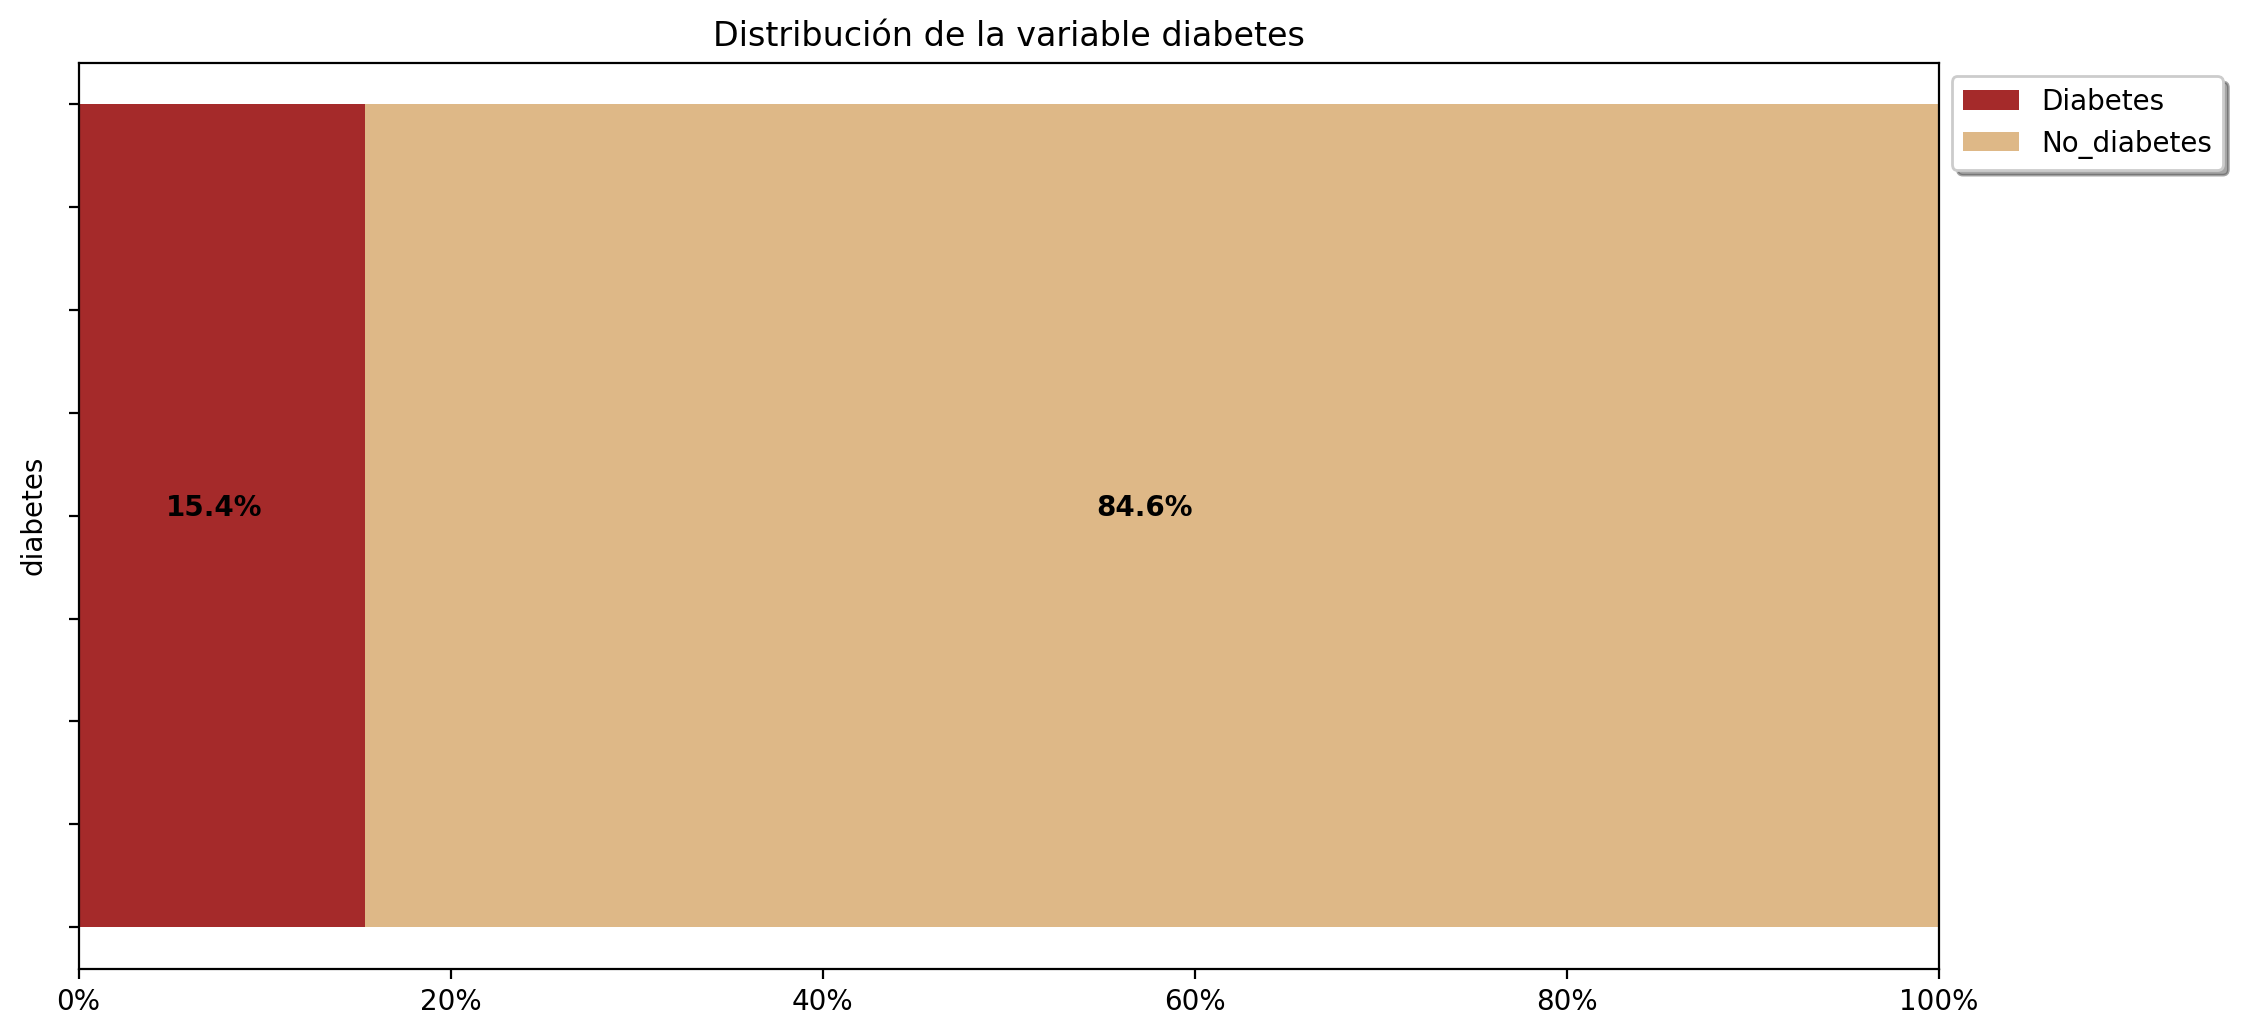

In [59]:
analisis_diabetes_pred.distribucion_variable_predecir()
plt.show()

Para este conjunto de datos sucede algo similar al ejercicio anterior, y es que no he visto dónde aplicamos los otros modelos al ejemplo de diabetes. Voy a ajustar los modelos estudiados antes y hacer la comparación.

In [60]:
# Variables Predictoras
X = datos_diabetes.drop(['diabetes'],axis=1)
X = pd.get_dummies(X, columns=['genero'])

# Variable a predecir
y = datos_diabetes['diabetes'].ravel()

#Partimos los datos en training-testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

#Estandarizamos los datos para aplicar SVM
X_train_scaled=X_train.copy()
X_test_scaled=X_test.copy()

for col in X_train.columns:
    sd_col=np.std(X_train[col])
    mean_col=np.mean(X_train[col])
    X_train_scaled[col]=[(obs-mean_col)/sd_col for obs in X_train[col]]
    X_test_scaled[col]=[(obs-mean_col)/sd_col for obs in X_test[col]]

In [61]:
modelos_ajustar=[]

instancia_knn = KNeighborsClassifier()
modelos_ajustar.append(instancia_knn)


instancia_arbol = DecisionTreeClassifier()
modelos_ajustar.append(instancia_arbol)


instancia_bosques = RandomForestClassifier()
modelos_ajustar.append(instancia_bosques)


instancia_tree = DecisionTreeClassifier(criterion="gini")
instancia_ada = AdaBoostClassifier(base_estimator=instancia_tree)
modelos_ajustar.append(instancia_ada)

instancia_xgb = GradientBoostingClassifier()
modelos_ajustar.append(instancia_xgb)

instancia_svm = SVC()
modelos_ajustar.append(instancia_svm)

instancia_bayes=GaussianNB()
modelos_ajustar.append(instancia_bayes)

In [68]:
df_comp=pd.DataFrame({})

start=time.time()

for modelo in modelos_ajustar:
    
        modelo.fit(X_train_scaled.values,y_train)
        prediccion = modelo.predict(X_test_scaled.values)
        MC = confusion_matrix(y_test, prediccion, labels=list(np.unique(y_train)))
        print(f"Matriz de confusión para {modelo}:")
        print(MC)
        medidas=MatConf(MC).dict_medidas
        df_este_modelo=pd.DataFrame({})
        for key in list(medidas.keys()):
            df_este_modelo[key]=[medidas[key]]
        df_comp= df_comp.append(df_este_modelo,ignore_index=True)
    
end=time.time()
print(f"Esta comparación de modelos tomó {end-start} segundos.")

df_comp.index=['KNN','Árbol de Decisión','Bosque Aleatorio','ADA Boost','XG Boost','SVM','Naive Bayes']

Matriz de confusión para KNeighborsClassifier():
[[ 6  6]
 [ 0 66]]
Matriz de confusión para DecisionTreeClassifier():
[[ 6  6]
 [ 3 63]]
Matriz de confusión para RandomForestClassifier():
[[ 6  6]
 [ 0 66]]
Matriz de confusión para AdaBoostClassifier(base_estimator=DecisionTreeClassifier()):
[[ 7  5]
 [ 4 62]]
Matriz de confusión para GradientBoostingClassifier():
[[ 7  5]
 [ 2 64]]
Matriz de confusión para SVC():
[[ 7  5]
 [ 0 66]]
Matriz de confusión para GaussianNB():
[[ 8  4]
 [ 5 61]]
Esta comparación de modelos tomó 0.5285577774047852 segundos.


In [69]:
df_comp=df_comp.sort_values(by=['Precisión Global'],ascending=False)
df_comp

,Precisión Global,Error Global,Precisión Positiva (PP),Precisión Negativa (PN),Proporción de Falsos Positivos (PFP),Proporción de Falsos Negativos (PFN),Asertividad Positiva (AP),Asertividad Negativa (AN)
SVM,0.935897,0.064103,1.000000,0.583333,0.416667,0.000000,0.929577,1.000000
KNN,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
Bosque Aleatorio,0.923077,0.076923,1.000000,0.500000,0.500000,0.000000,0.916667,1.000000
XG Boost,0.910256,0.089744,0.969697,0.583333,0.416667,0.030303,0.927536,0.777778
Árbol de Decisión,0.884615,0.115385,0.954545,0.500000,0.500000,0.045455,0.913043,0.666667
ADA Boost,0.884615,0.115385,0.939394,0.583333,0.416667,0.060606,0.925373,0.636364
Naive Bayes,0.884615,0.115385,0.924242,0.666667,0.333333,0.075758,0.938462,0.615385


Otra vez, SVM nos da el resultado superior en precisión global y en este caso Naive Bayes fue el clasificador que peor se desempeñó de todos los clasificadores testeados.

Finalmente, observamos si al hacer una selección de variables podemos mejorar el desempeño del clasificador de Naive Bayes. Voy a realizar esta selección de variables usando un bosque aleatorio.

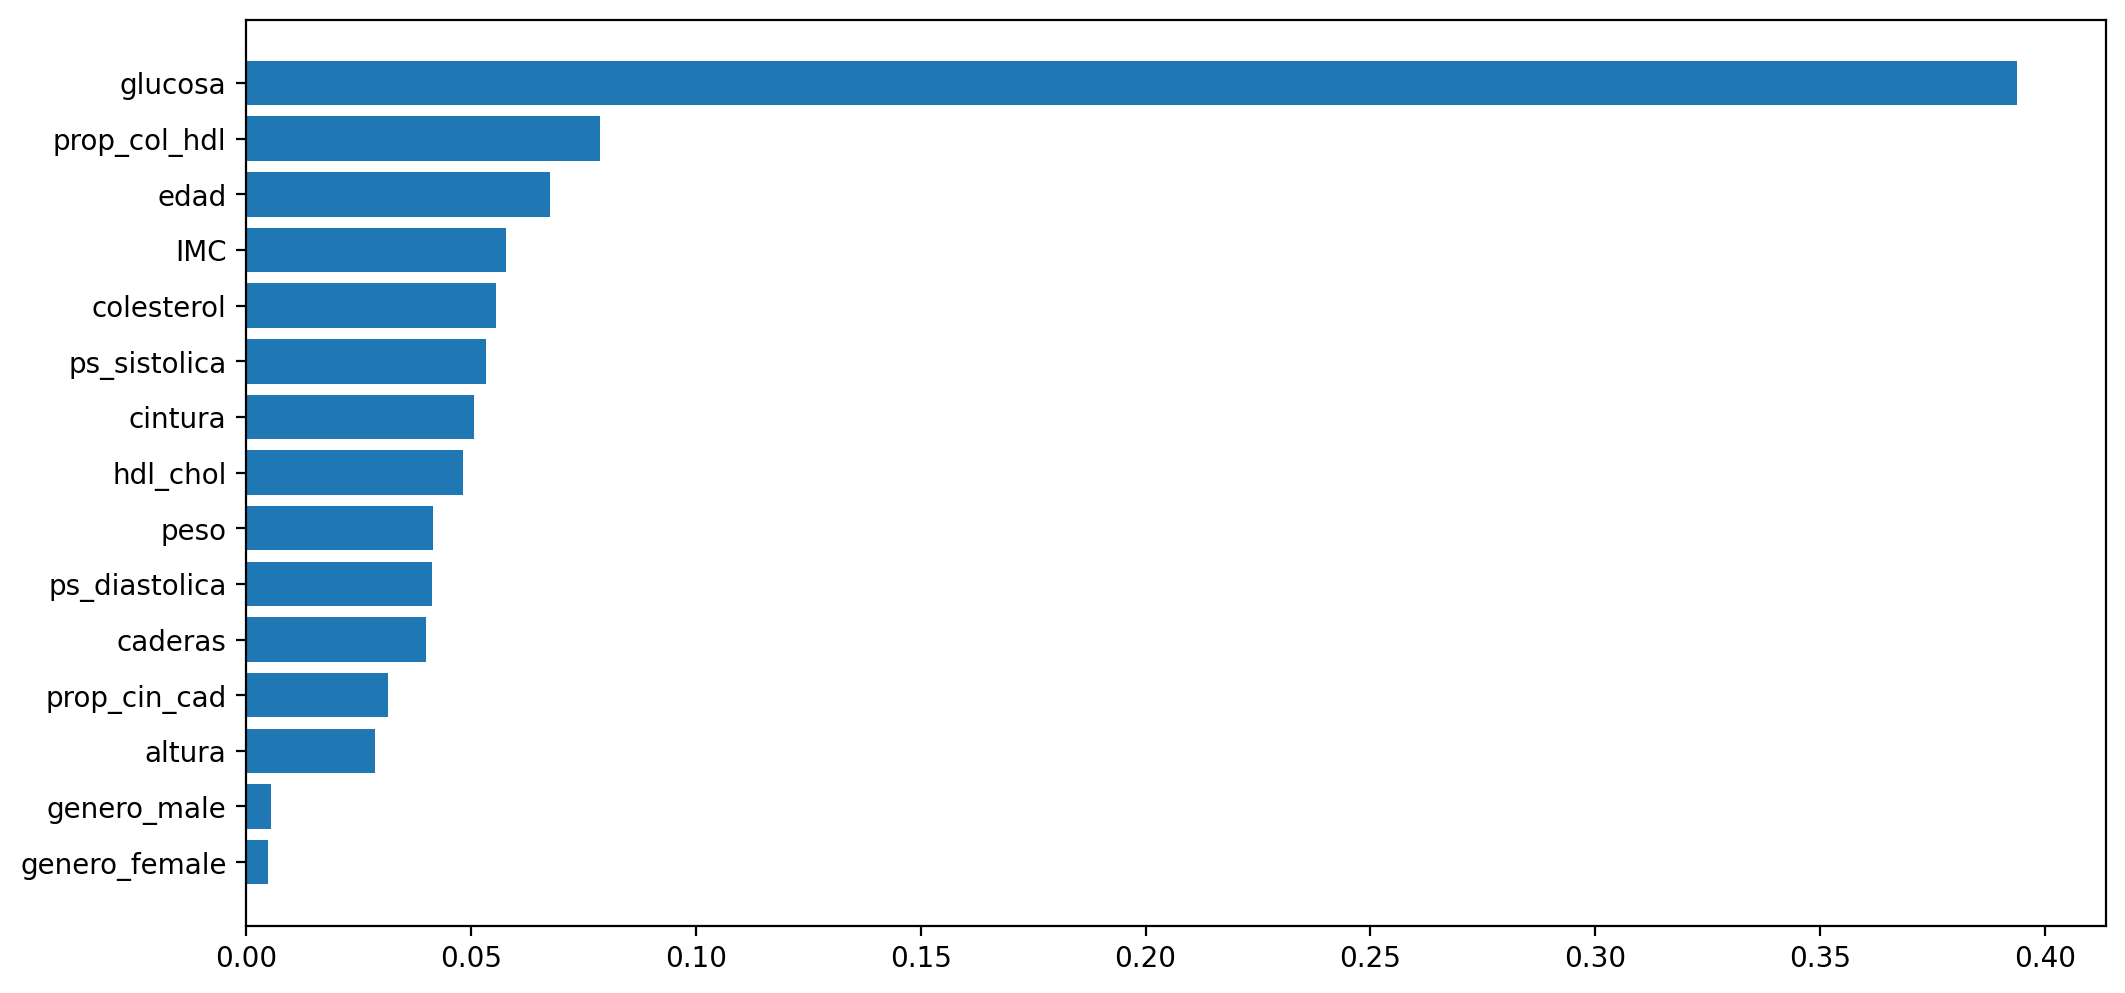

In [70]:
### Para Bosques Aleatorios ###
etiquetas=np.array(X_train_scaled.columns.tolist())

instancia_bosques = RandomForestClassifier()
instancia_bosques.fit(X_train_scaled.values,y_train)
importancia_bosques = np.array(instancia_bosques.feature_importances_)

orden = np.argsort(importancia_bosques)
importancia_bosques = importancia_bosques[orden]
etiquetas = etiquetas[orden]

fig, ax = plt.subplots(1,1, figsize = (12,6), dpi = 200)
ax.barh(etiquetas, importancia_bosques)
plt.show()

Para este modelo particular de bosques aleatorios, se obtuvo que las siguientes son las variables más importantes:

- `glucosa`
- `prop_col_hdl`
- `edad`
- `IMC`
- `colesterol`
- `ps_sistolica`

Procedemos a realizar un clasificador de Naive Bayes con estas variables solamente.

In [72]:
# Usamos los parámetros por defecto
bayes = GaussianNB()

analisis_diabetes_pred_6 = Analisis_Predictivo(
    datos_diabetes[['glucosa','prop_col_hdl','edad','IMC','colesterol','ps_sistolica','diabetes']],
    predecir = "diabetes",
    modelo = bayes, 
    train_size = 0.75,
    random_state = 45
)

resultados_6 = analisis_diabetes_pred_6.fit_predict_resultados()


Matriz de Confusión:
[[11  3]
 [ 2 82]]

Precisión Global:
0.9489795918367347

Error Global:
0.05102040816326525

Precisión por categoría:
   Diabetes  No_diabetes
0  0.785714      0.97619


Observamos que la predicción sí mejoró ligeramente al sólo considerar estas variables.

<div class='question_container'>
    <h2> Pregunta 3 </h2>
    <p>Para la siguiente tabla, la cual se vio en clase, suponga que se tiene una nueva fila o registro de la base de datos <code> t = (Isabel, F, 4, ?)</code>, prediga (a mano) si Isabel corresponde a la clase pequeño, mediano o alto.</p>
    <table>
      <tr>
        <th>Nombre</th>
        <th>Género</th>
        <th>Altura</th>
        <th>Clase</th>
      </tr>
        <tr>
        <td>Kristina</td> <td>F</td> <td> 1</td> <td> P</td>
        </tr>
        <tr>
         <td>Jim</td> <td>M</td> <td> 5</td> <td> A</td>
        </tr>
        <tr>
         <td>Maggi</td> <td>F</td> <td> 4</td> <td> M</td>
        </tr>
        <tr>
         <td>Martha</td> <td>F</td> <td> 4</td> <td> M</td>
        </tr>
        <tr>
         <td>Stephanie</td> <td>F</td> <td> 2</td> <td> P</td>
        </tr>
        <tr>
         <td>Bob</td> <td>M</td> <td> 4</td> <td> M</td>
        </tr>
        <tr>
         <td>Kathy</td> <td>F</td> <td> 1</td> <td> P</td>
        </tr>
        <tr>
         <td>Dave</td> <td>M</td> <td> 2</td> <td> P</td>
        </tr>
        <tr>
         <td>Worth</td> <td>M</td> <td> 6</td> <td> A</td>
        </tr>
        <tr>
         <td>Steven</td> <td>M</td> <td> 6</td> <td> A</td>
        </tr>
        <tr>
         <td>Debbie</td> <td>F</td> <td> 3</td> <td> M</td>
        </tr>
        <tr>
         <td>Todd</td> <td>M</td> <td> 5</td> <td> M</td>
        </tr>
        <tr>
         <td>Kim</td> <td>F</td> <td> 5</td> <td> M</td>
        </tr>
        <tr>
         <td>Amy</td> <td>F</td> <td> 3</td> <td> M</td>
        </tr>
        <tr>
         <td>Wynette</td> <td>F</td> <td>3</td> <td> M</td>
        </tr>
    </table>
</div>

**Respuesta:** Lo que tenemos que calcular son las tres probabilidades condicionales:
$$
\begin{align*}
P\bigl(\text{Clase = P} | X=(F,4)\bigr), \quad P\bigl(\text{Clase = M} | X=(F,4)\bigr) \quad \text{ y } \quad P\bigl(\text{Clase = A} | X=(F,4)\bigr)
\end{align*}
$$
Para eso utilizamos la fórmula de Bayes que, en cada caso, nos dice que
$$
P(\text{Clase = P} | X=(F,4)) = \frac{P\bigl(X=(F,4) |\text{Clase = P} \bigr)P\bigl(\text{Clase = P}\bigr)}{P\bigl(X=(F,4) |\text{Clase = P} \bigr)P\bigl(\text{Clase = P}\bigr)+P\bigl(X=(F,4) |\text{Clase = M} \bigr)P\bigl(\text{Clase = M}\bigr)+P\bigl(X=(F,4) |\text{Clase = A} \bigr)P\bigl(\text{Clase = A}\bigr)} \quad (1)
$$

$$
P(\text{Clase = M} | X=(F,4)) = \frac{P\bigl(X=(F,4) |\text{Clase = M} \bigr)P\bigl(\text{Clase = M}\bigr)}{P\bigl(X=(F,4) |\text{Clase = P} \bigr)P\bigl(\text{Clase = P}\bigr)+P\bigl(X=(F,4) |\text{Clase = M} \bigr)P\bigl(\text{Clase = M}\bigr)+P\bigl(X=(F,4) |\text{Clase = A} \bigr)P\bigl(\text{Clase = A}\bigr)} \quad (2)
$$

$$
P(\text{Clase = A} | X=(F,4)) = \frac{P\bigl(X=(F,4) |\text{Clase = A} \bigr)P\bigl(\text{Clase = A}\bigr)}{P\bigl(X=(F,4) |\text{Clase = P} \bigr)P\bigl(\text{Clase = P}\bigr)+P\bigl(X=(F,4) |\text{Clase = M} \bigr)P\bigl(\text{Clase = M}\bigr)+P\bigl(X=(F,4) |\text{Clase = A} \bigr)P\bigl(\text{Clase = A}\bigr)} \quad (3)
$$

Primero calculamos las probabilidades absolutas de las clases:

$$
\begin{align*}
&P(\text{Clase=P})=\frac{4}{15}\\
&P(\text{Clase=A})=\frac{3}{15}\\
&P(\text{Clase=M})=\frac{8}{15}
\end{align*}
$$

Ahora tenemos que calcular las probabilidades condicionales:

$$
\begin{align*}
P\bigl(X=(F,4) |\text{Clase = P} \bigr) &=P\bigl(\text{Genero=F} |\text{Clase = P} \bigr) \cdot P\bigl(\text{Altura=4} |\text{Clase = P} \bigr)\\
&= \frac{3}{4} \cdot \frac{0}{4}\\
&=0.
\end{align*}
$$

$$
\begin{align*}
P\bigl(X=(F,4) |\text{Clase = M} \bigr) &=P\bigl(\text{Genero=F} |\text{Clase = M} \bigr) \cdot P\bigl(\text{Altura=4} |\text{Clase = M} \bigr)\\
&= \frac{6}{8}\cdot \frac{3}{8} \\
&= \frac{9}{4}.
\end{align*}
$$

$$
\begin{align*}
P\bigl(X=(F,4) |\text{Clase = A} \bigr) &=P\bigl(\text{Genero=F} |\text{Clase = A} \bigr) \cdot P\bigl(\text{Altura=4} |\text{Clase = A} \bigr)\\
&=\frac{0}{3}\cdot\frac{0}{3} \\
&=0.
\end{align*}
$$

De éstos cálculos es inmediato ver que la probabilidad máxima se alcanzará con la clase M, ya que es la única que no dará cero (de hecho dará igual a $1$). Así que ésta es la clase en la que se clasificará Isabel.

<div class='question_container'>
    <h2> Pregunta 4 </h2>
    <p>Para la siguiente tabla, la cual se vio en clase, suponga que se tiene una nueva fila o registro <code>12 = (1, 3, 2, 4, ?)</code> en la base de datos, prediga (a mano) si el individuo corresponde a un buen pagador o a un mal pagador.</p>
    <table>
        <tr>
            <th>Id</th>
            <th>Monto.Crédito</th>
            <th>Ingreso.Neto</th>
            <th>Monto.Cuota</th>
            <th>Grado.Academico</th>
            <th>Buen.Pagador</th>
        </tr>
            <tr>
            <td>1</td> <td>2</td> <td> 4</td> <td> 1</td> <td> 4</td> <td> Sí</td>
            </tr>
            <tr>
            <td>2</td> <td> 2</td> <td> 3</td> <td> 1</td> <td> 4</td> <td> Sí</td>
            </tr>
            <tr>
            <td>3</td> <td> 4</td> <td> 1</td> <td> 4</td> <td> 2</td> <td> No</td>
            </tr>
            <tr>
            <td>4</td> <td> 1</td> <td> 4</td> <td> 1</td> <td> 4</td> <td> Sí</td>
            </tr>
            <tr>
            <td>5</td> <td> 3</td> <td> 3</td> <td> 3</td> <td> 2</td> <td> No</td>
            </tr>
            <tr>
            <td>6</td> <td> 3</td> <td> 4</td> <td> 1</td> <td> 4</td> <td> Sí</td>
            </tr>
            <tr>
            <td>7</td> <td> 4</td> <td> 2</td> <td> 3</td> <td> 2</td> <td> No</td>
            </tr>
            <tr>
            <td>8</td> <td> 4</td> <td> 1</td> <td> 3</td> <td> 2</td> <td> No</td>
            </tr>
            <tr>
            <td>9</td> <td> 3</td> <td> 4</td> <td> 1</td> <td> 3</td> <td> Sí</td>
            </tr>
            <tr>
            <td>10</td> <td> 1</td> <td> 3</td> <td> 2</td> <td> 4</td> <td> Sí</td>
            </tr>
            <tr>
            <td>11</td> <td> 1</td> <td> 4</td> <td> 2</td> <td> 4</td> <td> Sí</td>
            </tr>
        </table>
</div>

**Respuesta:** Lo que tenemos que calcular son las dos probabilidades condicionales:
$$
\begin{align*}
P\bigl(\text{Buen.Pagador=Si} | X=(1,3,2,4)\bigr)\quad \text{ y } \quad P\bigl(\text{Buen.Pagador=No} | X=(1,3,2,4)\bigr) 
\end{align*}
$$
Para eso utilizamos la fórmula de Bayes que, en cada caso, nos dice que
$$
\begin{align*}
&P(\text{Buen.Pagador=Si} | X=(1,3,2,4)) \\
&= \frac{P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=Si} \bigr)P\bigl(\text{Buen.Pagador=Si}\bigr)}{P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=Si} \bigr)P\bigl(\text{Buen.Pagador=Si}\bigr)+P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=No} \bigr)P\bigl(\text{Buen.Pagador=No}\bigr)} \quad (1)
\end{align*}
$$

$$
\begin{align*}
&P(\text{Buen.Pagador=No} | X=(1,3,2,4))\\
&= \frac{P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=No} \bigr)P\bigl(\text{Buen.Pagador=No}\bigr)}{P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=Si} \bigr)P\bigl(\text{Buen.Pagador=Si}\bigr)+P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=No} \bigr)P\bigl(\text{Buen.Pagador=No}\bigr)} \quad (2)
\end{align*}
$$

Primero calculamos entonces las probabilidades absolutas de ambas clases:

$$
P\bigl(\text{Buen.Pagador=Si}\bigr)=\frac{7}{11}.
$$

$$
P\bigl(\text{Buen.Pagador=No}\bigr)=\frac{4}{11}.
$$

Ahora calculamos las otras probabilidades condicionales:

$$
\begin{align*}
&P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=Si} \bigr) = \\
&P\bigl(X_1=1 |\text{Buen.Pagador=Si} \bigr)\cdot P\bigl(X_2=3 |\text{Buen.Pagador=Si} \bigr) \cdot P\bigl(X_3=2 |\text{Buen.Pagador=Si} \bigr) \cdot P\bigl(X_4=4 |\text{Buen.Pagador=Si} \bigr) \\
&=\frac{3}{7}\cdot\frac{2}{7}\cdot\frac{2}{7}\cdot\frac{6}{7}\\
&=\frac{72}{2401}.
\end{align*}
$$

Por otro lado:

$$
\begin{align*}
&P\bigl(X=(1,3,2,4) |\text{Buen.Pagador=No} \bigr) = \\
&P\bigl(X_1=1 |\text{Buen.Pagador=No} \bigr)\cdot P\bigl(X_2=3 |\text{Buen.Pagador=No} \bigr) \cdot P\bigl(X_3=2 |\text{Buen.Pagador=No} \bigr) \cdot P\bigl(X_4=4 |\text{Buen.Pagador=No} \bigr) \\
&=\frac{0}{7}\cdot\frac{1}{7}\cdot\frac{0}{7}\cdot\frac{0}{7}\\
&=0
\end{align*}
$$

Otra vez sucede lo mismo que en el ejercicio anterior, en donde claramente al sustituir en las probabilidades tendremos que este individuo será clasificado como <code>Buen.Pagador=Si</code>.

*Comentario:* Tengo entendido que algunas veces se usa el corrector de Laplace para enfrentar el problema de probabilidad cero en este tipo de clasificadores: [Laplace Smoothing in Naive Bayes](https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece#:~:text=Laplace%20smoothing%20is%20a%20smoothing%20technique%20that%20helps%20tackle%20the,the%20positive%20and%20negative%20reviews.), no sé si lo vimos en clase pero quería comentarlo. Gracias!